In [1]:
data_dir = '/workspace'
import keras
from keras import layers
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
import os
import random
from pathlib import Path
import warnings
warnings.filterwarnings('ignore')

2025-04-11 10:17:42.314924: I tensorflow/core/util/port.cc:153] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2025-04-11 10:17:42.384663: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:467] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1744366662.430884    1287 cuda_dnn.cc:8579] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1744366662.443271    1287 cuda_blas.cc:1407] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
W0000 00:00:1744366662.508673    1287 computation_placer.cc:177] computation placer already registered. Please check linkage and avoid linking 

In [2]:
def load_training_labels(data_dir='./', num_samples=None, balanced=False):
    training_labels = pd.read_csv(os.path.join(data_dir, 'train_labels.csv'))
    training_labels['label'] = training_labels['label'].astype('bool')
    if num_samples is None:
        return training_labels.sample(frac=1).reset_index(drop=True)
    
    if balanced:
        pos = training_labels[training_labels['label']].sample(num_samples // 2)
        neg = training_labels[~training_labels['label']].sample(num_samples // 2)
        training_labels = pd.concat([pos, neg]).sample(frac=1).reset_index(drop=True)
    else:
        training_labels = training_labels.sample(num_samples).reset_index(drop=True)

    return training_labels


def get_training_images(training_labels, data_dir='./'):
    images = np.array(
        [keras.utils.img_to_array(keras.utils.load_img(os.path.join(data_dir, 'train', f'{id}.tif')))
         for id in training_labels['id']])
    return images


def get_test_images(data_dir='./'):
    test_image_files = [f for f in os.listdir(os.path.join(data_dir, "test")) if f.endswith(".tif")]
    test_ids = [Path(f).stem for f in test_image_files]
    test_images = np.array(
        [keras.utils.img_to_array(keras.utils.load_img(os.path.join(data_dir, 'test', f)))
         for f in test_image_files])
    return test_images, test_ids


def plot_training_history(history):
    # Plot the training and validation loss and accuracy
    plt.figure(figsize=(12, 4))
    plt.subplot(1, 2, 1)
    plt.plot(history.history['loss'], label='Training Loss')
    plt.plot(history.history['val_loss'], label='Validation Loss')
    plt.title('Loss')
    plt.legend()
    plt.subplot(1, 2, 2)
    plt.plot(history.history['accuracy'], label='Training Accuracy')
    plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
    plt.title('Accuracy')
    plt.legend()
    plt.show()


In [3]:
def train_model(model, model_name, X, y, epochs=100, batch_size=32, validation_split=0.2):
    checkpointer = keras.callbacks.ModelCheckpoint(
        f'{model_name}.best_weights.keras', 
        save_best_only=True,
        verbose=1,
        monitor='val_AUC',
        mode='max')
    early_stopping = keras.callbacks.EarlyStopping(
        patience=10,
        verbose=1,
        monitor='val_AUC',
        mode='max')

    history = model.fit(X, y, epochs=epochs, batch_size=batch_size, validation_split=validation_split, 
                        callbacks=[checkpointer, early_stopping])
    
    model.load_weights(f'{model_name}.best_weights.keras')
    plot_training_history(history)
    return model # , history


def evaluate_model_and_print_results(model, X_test, y_test):
    test_loss, test_accuracy, test_auc = model.evaluate(X_test, y_test)
    print(f'Test Loss: {test_loss}')
    print(f'Test Accuracy: {test_accuracy}')
    print(f'Test AUC: {test_auc}')


def generate_submission(model, test_images, test_ids, model_name):
    test_predictions = model.predict(test_images)
    submission = pd.DataFrame({"id": test_ids, "label": test_predictions.flatten()})
    output_file = f'submission_{model_name}.csv'
    submission.to_csv(output_file, index=False)
    print(f"Submission saved to {output_file}")

In [4]:
training_labels = load_training_labels(data_dir)
print(training_labels.shape)
print(training_labels.head())
print(training_labels['label'].value_counts())

(220025, 2)
                                         id  label
0  f534dfbd6fa6c572b78b222940837a97572a9618  False
1  654a43875db2af62d7536f43ec75d1b310bc1758  False
2  fea4f996f4a49b6ab59b9073203b79b3db01d620   True
3  cfee7ec8209c2a3cf65b69a665ddaaed1418267d   True
4  6483dc52f92adcfab9d2210f1b525212362031ba  False
label
False    130908
True      89117
Name: count, dtype: int64


In [5]:
# Prepare the training data
X_train = get_training_images(training_labels, data_dir)
y_train = training_labels['label'].values

print(X_train.shape)
print(y_train.shape)


(220025, 96, 96, 3)
(220025,)


In [6]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(X_train, y_train, test_size=0.25, random_state=77)

print(X_train.shape)
print(y_train.shape)

print(X_test.shape)
print(y_test.shape)

(165018, 96, 96, 3)
(165018,)
(55007, 96, 96, 3)
(55007,)


Epoch 1/100


I0000 00:00:1744367234.762204    1821 service.cc:152] XLA service 0x7ad4900187b0 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
I0000 00:00:1744367234.762232    1821 service.cc:160]   StreamExecutor device (0): NVIDIA A100-SXM4-80GB, Compute Capability 8.0
2025-04-11 10:27:14.827319: I tensorflow/compiler/mlir/tensorflow/utils/dump_mlir_util.cc:269] disabling MLIR crash reproducer, set env var `MLIR_CRASH_REPRODUCER_DIRECTORY` to enable.
I0000 00:00:1744367235.154088    1821 cuda_dnn.cc:529] Loaded cuDNN version 90300
Could not load symbol cuFuncGetName. Error: /usr/lib/x86_64-linux-gnu/libcuda.so.1: undefined symbol: cuFuncGetName


  25/4126 ━━━━━━━━━━━━━━━━━━━━ 26s 7ms/step - AUC: 0.4959 - accuracy: 0.5350 - loss: 29.2816   

I0000 00:00:1744367240.027377    1821 device_compiler.h:188] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


4126/4126 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - AUC: 0.7545 - accuracy: 0.7125 - loss: 1.1695 
Epoch 1: val_AUC improved from -inf to 0.81541, saving model to cnn_32_model1.best_weights.keras
4126/4126 ━━━━━━━━━━━━━━━━━━━━ 47s 10ms/step - AUC: 0.7545 - accuracy: 0.7125 - loss: 1.1694 - val_AUC: 0.8154 - val_accuracy: 0.7627 - val_loss: 0.5513
Epoch 2/100
4126/4126 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - AUC: 0.8138 - accuracy: 0.7581 - loss: 0.5205 
Epoch 2: val_AUC improved from 0.81541 to 0.83030, saving model to cnn_32_model1.best_weights.keras
4126/4126 ━━━━━━━━━━━━━━━━━━━━ 35s 8ms/step - AUC: 0.8138 - accuracy: 0.7581 - loss: 0.5205 - val_AUC: 0.8303 - val_accuracy: 0.7667 - val_loss: 0.5030
Epoch 3/100
4121/4126 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - AUC: 0.8149 - accuracy: 0.7590 - loss: 0.5199 
Epoch 3: val_AUC did not improve from 0.83030
4126/4126 ━━━━━━━━━━━━━━━━━━━━ 34s 8ms/step - AUC: 0.8149 - accuracy: 0.7590 - loss: 0.5199 - val_AUC: 0.8173 - val_accuracy: 0.7208 - val_loss: 0.5881


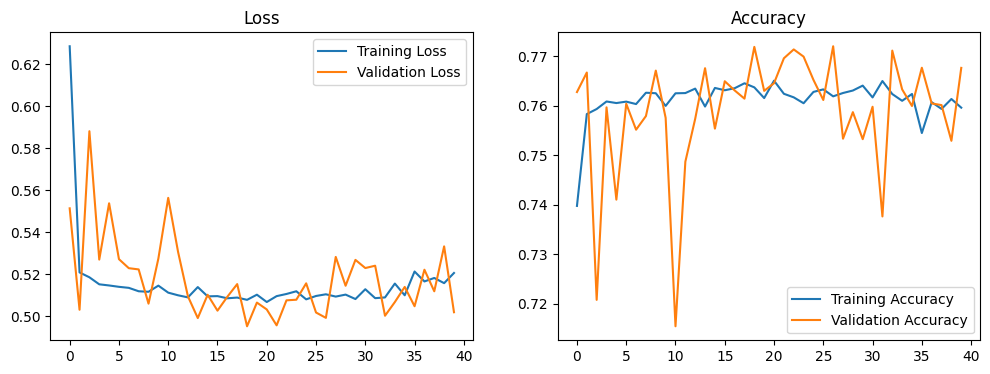

1719/1719 ━━━━━━━━━━━━━━━━━━━━ 10s 5ms/step - AUC: 0.8398 - accuracy: 0.7571 - loss: 0.5211
Test Loss: 0.5260485410690308
Test Accuracy: 0.7542676329612732
Test AUC: 0.836492121219635


In [8]:
model1 = keras.Sequential([
    layers.InputLayer(shape=(96, 96, 3)),
    layers.CenterCrop(32, 32),
    #layers.Rescaling(1. / 255),
    layers.Conv2D(48, 3, activation='relu'),
    layers.MaxPooling2D(),
    layers.Dropout(0.25),
    layers.Conv2D(96, 3, activation='relu'),
    layers.MaxPooling2D(),
    layers.Dropout(0.25),
    layers.Conv2D(192, 3, activation='relu'),
    layers.MaxPooling2D(),
    layers.Dropout(0.25),
    #layers.Conv2D(384, 3, activation='relu'),
    #layers.MaxPooling2D(),
    #layers.BatchNormalization(),
    layers.Flatten(),
    layers.Dense(256, activation='relu'),
    layers.Dropout(0.5),
    #layers.Dense(1024, activation='relu'),
    #layers.Dropout(0.5),
    layers.Dense(1, activation='sigmoid')    
])

model1.compile(optimizer=keras.optimizers.Adam(), loss=keras.losses.BinaryCrossentropy(), metrics=['accuracy', 'AUC'])

model1 = train_model(model1, 'cnn_32_model1', X_train, y_train)
evaluate_model_and_print_results(model1, X_test, y_test)

In [13]:
model1.summary()

Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ center_crop_1 (CenterCrop)      │ (None, 32, 32, 3)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_3 (Conv2D)               │ (None, 30, 30, 48)     │         1,344 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_3 (MaxPooling2D)  │ (None, 15, 15, 48)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_4 (Dropout)             │ (None, 15, 15, 48)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_4 (Conv2D)               │ (None, 13, 13, 96)     │        41,568 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_4 (MaxPooling2D)  │ (None, 6, 6, 96)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_5 (Dropout)             │ (None, 6, 6, 96)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_5 (Conv2D)               │ (None, 4, 4, 192)      │       166,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_5 (MaxPooling2D)  │ (None, 2, 2, 192)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_6 (Dropout)             │ (None, 2, 2, 192)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_1 (Flatten)             │ (None, 768)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 256)            │       196,864 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_7 (Dropout)             │ (None, 256)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3 (Dense)                 │ (None, 1)              │           257 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 1,218,341 (4.65 MB)

 Trainable params: 406,113 (1.55 MB)

 Non-trainable params: 0 (0.00 B)

 Optimizer params: 812,228 (3.10 MB)

In [11]:
def create_cnn_model(cnn_layers, center_crop=32, image_rescaling=False, fc_layers=[64], fc_regularization=None, fc_dropout_rate=0.5):
    model = keras.Sequential([
        layers.InputLayer(shape=(96, 96, 3)),
        layers.CenterCrop(center_crop, center_crop)
    ])
    if image_rescaling:
        model.add(layers.Rescaling(1. / 255))

    model.add(cnn_layers)
    model.add(layers.Flatten())
    for n_units in fc_layers:
        model.add(layers.Dense(n_units, activation='relu'))
        if fc_regularization == 'batch':
            model.add(layers.BatchNormalization())
        elif fc_regularization == 'dropout':
            model.add(layers.Dropout(fc_dropout_rate))

    model.add(layers.Dense(1, activation='sigmoid'))
    return model


def generate_cnn_layers(cnn_layers=[(48, 3, True), (96, 3, True), (192, 3, True)], regularization=None, dropout_rate=0.25):
    output = keras.Sequential()
    for layer in cnn_layers:
        output.add(layers.Conv2D(layer[0], layer[1], activation='relu'))
        if layer[2]:
            output.add(layers.MaxPooling2D())
        if regularization == 'batch':
            output.add(layers.BatchNormalization())
        elif regularization == 'dropout':
            output.add(layers.Dropout(dropout_rate))
    return output


In [12]:
# We can probably generate cnn_layers too
cnn_layers = generate_cnn_layers(
    cnn_layers=[(48, 3, True), (96, 3, True), (192, 3, True)],
    regularization='dropout',
    dropout_rate=0.25)

model2 = create_cnn_model(cnn_layers, center_crop=48, image_rescaling=True, fc_layers=[768], fc_regularization='dropout')
model2.summary()


Model: "sequential_4"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ center_crop_3 (CenterCrop)      │ (None, 48, 48, 3)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ rescaling_1 (Rescaling)         │ (None, 48, 48, 3)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ sequential_3 (Sequential)       │ (None, 4, 4, 192)      │       208,992 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_2 (Flatten)             │ (None, 3072)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_4 (Dense)                 │ (None, 768)            │     2,360,064 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_14 (Dropout)            │ (None, 768)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_5 (Dense)                 │ (None, 1)              │           769 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 2,569,825 (9.80 MB)

 Trainable params: 2,569,825 (9.80 MB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/100
4126/4126 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - AUC: 0.7849 - accuracy: 0.7221 - loss: 0.0668 
Epoch 1: val_AUC improved from -inf to 0.85565, saving model to cnn_48_model2.best_weights.keras
4126/4126 ━━━━━━━━━━━━━━━━━━━━ 52s 11ms/step - AUC: 0.7849 - accuracy: 0.7221 - loss: 0.0668 - val_AUC: 0.8556 - val_accuracy: 0.7816 - val_loss: 0.0634
Epoch 2/100
4124/4126 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - AUC: 0.8593 - accuracy: 0.7870 - loss: 0.0570 
Epoch 2: val_AUC improved from 0.85565 to 0.87608, saving model to cnn_48_model2.best_weights.keras
4126/4126 ━━━━━━━━━━━━━━━━━━━━ 36s 9ms/step - AUC: 0.8593 - accuracy: 0.7870 - loss: 0.0570 - val_AUC: 0.8761 - val_accuracy: 0.7570 - val_loss: 0.0702
Epoch 3/100
4125/4126 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - AUC: 0.8788 - accuracy: 0.8047 - loss: 0.0532 
Epoch 3: val_AUC improved from 0.87608 to 0.89712, saving model to cnn_48_model2.best_weights.keras
4126/4126 ━━━━━━━━━━━━━━━━━━━━ 35s 8ms/step - AUC: 0.8788 - accuracy: 0.8047 - loss: 0

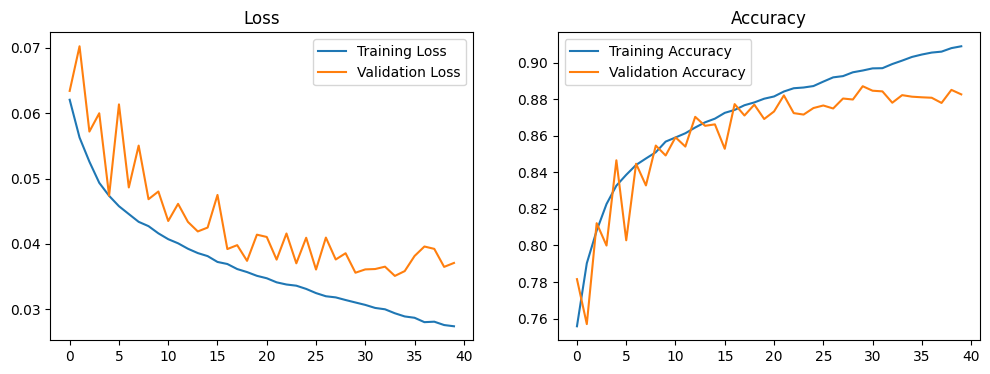

1719/1719 ━━━━━━━━━━━━━━━━━━━━ 9s 5ms/step - AUC: 0.9523 - accuracy: 0.8916 - loss: 0.0349
Test Loss: 0.03540787845849991
Test Accuracy: 0.9513777494430542
Test AUC: 0.8895776867866516


In [14]:
model2.compile(optimizer=keras.optimizers.Adam(learning_rate=0.0001), loss=keras.losses.BinaryFocalCrossentropy(apply_class_balancing=True, alpha=0.4), metrics=['accuracy', 'AUC'])
model2 = train_model(model2, 'cnn_48_model2', X_train, y_train)
evaluate_model_and_print_results(model2, X_test, y_test)

Epoch 1/100
4126/4126 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - AUC: 0.8085 - accuracy: 0.7499 - loss: 0.0801 
Epoch 1: val_AUC improved from -inf to 0.80328, saving model to cnn_48_model3.best_weights.keras
4126/4126 ━━━━━━━━━━━━━━━━━━━━ 51s 11ms/step - AUC: 0.8085 - accuracy: 0.7499 - loss: 0.0801 - val_AUC: 0.8033 - val_accuracy: 0.7596 - val_loss: 0.0655
Epoch 2/100
4119/4126 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - AUC: 0.8812 - accuracy: 0.8090 - loss: 0.0531 
Epoch 2: val_AUC improved from 0.80328 to 0.89055, saving model to cnn_48_model3.best_weights.keras
4126/4126 ━━━━━━━━━━━━━━━━━━━━ 40s 10ms/step - AUC: 0.8812 - accuracy: 0.8090 - loss: 0.0531 - val_AUC: 0.8905 - val_accuracy: 0.8255 - val_loss: 0.0537
Epoch 3/100
4125/4126 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - AUC: 0.8976 - accuracy: 0.8226 - loss: 0.0495 
Epoch 3: val_AUC did not improve from 0.89055
4126/4126 ━━━━━━━━━━━━━━━━━━━━ 39s 9ms/step - AUC: 0.8976 - accuracy: 0.8226 - loss: 0.0495 - val_AUC: 0.8566 - val_accuracy: 0.7985 - val_

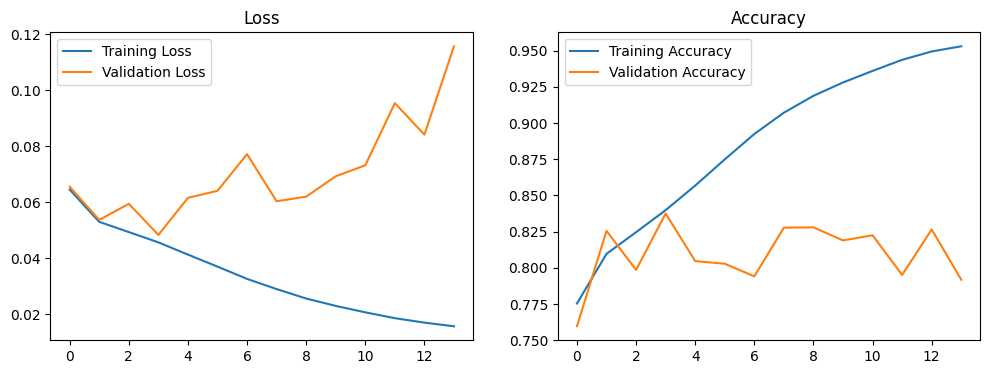

1719/1719 ━━━━━━━━━━━━━━━━━━━━ 10s 6ms/step - AUC: 0.9102 - accuracy: 0.8444 - loss: 0.0475
Test Loss: 0.04827237129211426
Test Accuracy: 0.9075695276260376
Test AUC: 0.8410929441452026


In [15]:
cnn_layers = generate_cnn_layers(
    cnn_layers=[(48, 3, True), (96, 3, True), (192, 3, True)],
    regularization='batch')

model3 = create_cnn_model(cnn_layers, center_crop=48, image_rescaling=True, fc_layers=[768], fc_regularization='batch')
# model3.summary()
model3.compile(optimizer=keras.optimizers.Adam(learning_rate=0.0001), 
               loss=keras.losses.BinaryFocalCrossentropy(apply_class_balancing=True, alpha=0.4), 
               metrics=['accuracy', 'AUC'])
model3 = train_model(model3, 'cnn_48_model3', X_train, y_train)
evaluate_model_and_print_results(model3, X_test, y_test)

Epoch 1/100
4126/4126 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - AUC: 0.7915 - accuracy: 0.7259 - loss: 0.0663
Epoch 1: val_AUC improved from -inf to 0.86438, saving model to cnn_64_model4.best_weights.keras
4126/4126 ━━━━━━━━━━━━━━━━━━━━ 56s 12ms/step - AUC: 0.7915 - accuracy: 0.7259 - loss: 0.0663 - val_AUC: 0.8644 - val_accuracy: 0.7824 - val_loss: 0.0658
Epoch 2/100
4126/4126 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - AUC: 0.8698 - accuracy: 0.7947 - loss: 0.0551 
Epoch 2: val_AUC improved from 0.86438 to 0.88771, saving model to cnn_64_model4.best_weights.keras
4126/4126 ━━━━━━━━━━━━━━━━━━━━ 41s 10ms/step - AUC: 0.8698 - accuracy: 0.7947 - loss: 0.0551 - val_AUC: 0.8877 - val_accuracy: 0.7689 - val_loss: 0.0695
Epoch 3/100
4122/4126 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - AUC: 0.8944 - accuracy: 0.8188 - loss: 0.0501 
Epoch 3: val_AUC improved from 0.88771 to 0.90598, saving model to cnn_64_model4.best_weights.keras
4126/4126 ━━━━━━━━━━━━━━━━━━━━ 43s 10ms/step - AUC: 0.8944 - accuracy: 0.8188 - loss:

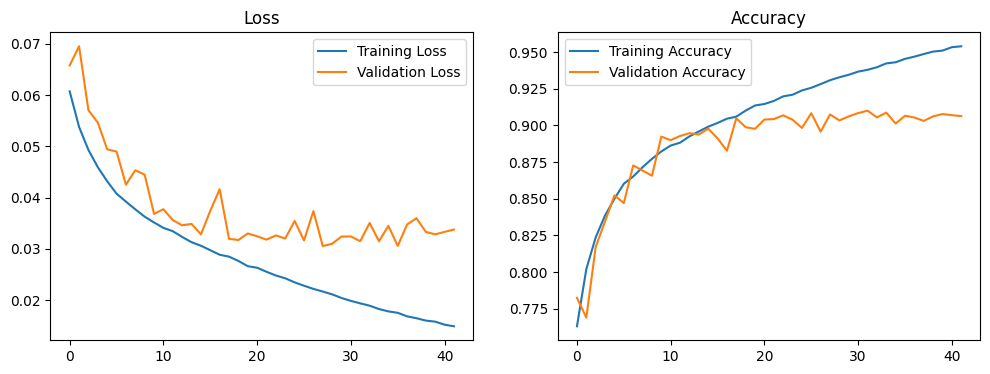

1719/1719 ━━━━━━━━━━━━━━━━━━━━ 9s 5ms/step - AUC: 0.9670 - accuracy: 0.9135 - loss: 0.0303
Test Loss: 0.031336016952991486
Test Accuracy: 0.9111204147338867
Test AUC: 0.9656600952148438


In [16]:
cnn_layers = generate_cnn_layers(
    cnn_layers=[(48, 3, True), (96, 3, True), (192, 3, True)],
    regularization='dropout',
    dropout_rate=0.25)

model4 = create_cnn_model(cnn_layers, center_crop=64, image_rescaling=True, fc_layers=[768], fc_regularization='dropout')

model4.compile(optimizer=keras.optimizers.Adam(learning_rate=0.0001), 
               loss=keras.losses.BinaryFocalCrossentropy(apply_class_balancing=True, alpha=0.4), 
               metrics=['accuracy', 'AUC'])
model4 = train_model(model4, 'cnn_64_model4', X_train, y_train)
evaluate_model_and_print_results(model4, X_test, y_test)

Epoch 1/100
4126/4126 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step - AUC: 0.8076 - accuracy: 0.7432 - loss: 0.0635 
Epoch 1: val_AUC improved from -inf to 0.86275, saving model to cnn_96_model5.best_weights.keras
4126/4126 ━━━━━━━━━━━━━━━━━━━━ 86s 19ms/step - AUC: 0.8076 - accuracy: 0.7432 - loss: 0.0635 - val_AUC: 0.8627 - val_accuracy: 0.7011 - val_loss: 0.0780
Epoch 2/100
4124/4126 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - AUC: 0.8924 - accuracy: 0.8182 - loss: 0.0506 
Epoch 2: val_AUC improved from 0.86275 to 0.91043, saving model to cnn_96_model5.best_weights.keras
4126/4126 ━━━━━━━━━━━━━━━━━━━━ 65s 16ms/step - AUC: 0.8924 - accuracy: 0.8182 - loss: 0.0506 - val_AUC: 0.9104 - val_accuracy: 0.7352 - val_loss: 0.0737
Epoch 3/100
4126/4126 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - AUC: 0.9223 - accuracy: 0.8482 - loss: 0.0437 
Epoch 3: val_AUC improved from 0.91043 to 0.94426, saving model to cnn_96_model5.best_weights.keras
4126/4126 ━━━━━━━━━━━━━━━━━━━━ 65s 16ms/step - AUC: 0.9223 - accuracy: 0.8482 - lo

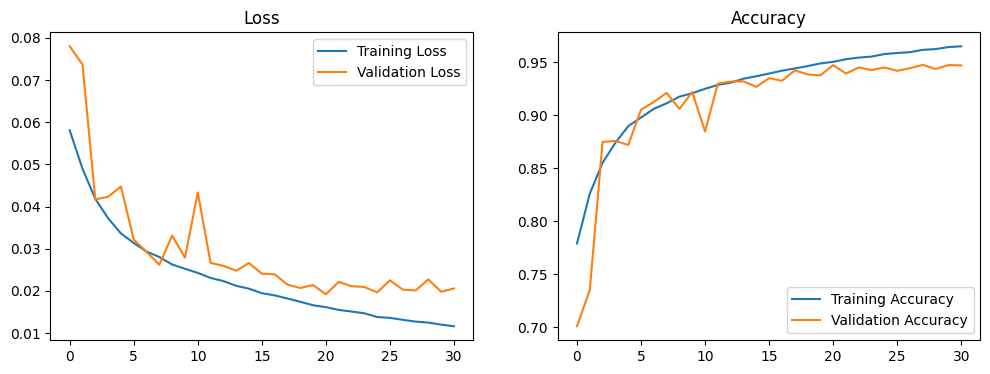

1719/1719 ━━━━━━━━━━━━━━━━━━━━ 12s 7ms/step - AUC: 0.9863 - accuracy: 0.9468 - loss: 0.0189
Test Loss: 0.019166670739650726
Test Accuracy: 0.9474612474441528
Test AUC: 0.9860718250274658


In [18]:
cnn_layers = generate_cnn_layers(
    cnn_layers=[(48, 3, True), (96, 3, True), (192, 3, True), (384, 3, True)],
    regularization='dropout',
    dropout_rate=0.25)

model5 = create_cnn_model(cnn_layers, center_crop=96, image_rescaling=True, fc_layers=[768], fc_regularization='dropout')

model5.compile(optimizer=keras.optimizers.Adam(learning_rate=0.0001), 
               loss=keras.losses.BinaryFocalCrossentropy(apply_class_balancing=True, alpha=0.4), 
               metrics=['accuracy', 'AUC'])
model5 = train_model(model5, 'cnn_96_model5', X_train, y_train)
evaluate_model_and_print_results(model5, X_test, y_test)

Epoch 1/100
4126/4126 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - AUC: 0.7992 - accuracy: 0.7333 - loss: 0.0649

2025-04-11 12:33:33.553910: I external/local_xla/xla/stream_executor/cuda/subprocess_compilation.cc:346] ptxas warning : Registers are spilled to local memory in function 'gemm_fusion_dot_152', 196 bytes spill stores, 196 bytes spill loads

2025-04-11 12:33:33.561153: I external/local_xla/xla/stream_executor/cuda/subprocess_compilation.cc:346] ptxas warning : Registers are spilled to local memory in function 'gemm_fusion_dot_152', 32 bytes spill stores, 32 bytes spill loads

2025-04-11 12:33:33.655494: I external/local_xla/xla/stream_executor/cuda/subprocess_compilation.cc:346] ptxas warning : Registers are spilled to local memory in function 'gemm_fusion_dot_152', 128 bytes spill stores, 188 bytes spill loads




Epoch 1: val_AUC improved from -inf to 0.87735, saving model to cnn_64_model6.best_weights.keras
4126/4126 ━━━━━━━━━━━━━━━━━━━━ 61s 13ms/step - AUC: 0.7992 - accuracy: 0.7333 - loss: 0.0649 - val_AUC: 0.8773 - val_accuracy: 0.7977 - val_loss: 0.0615
Epoch 2/100
4126/4126 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - AUC: 0.8773 - accuracy: 0.8032 - loss: 0.0537 
Epoch 2: val_AUC improved from 0.87735 to 0.89027, saving model to cnn_64_model6.best_weights.keras
4126/4126 ━━━━━━━━━━━━━━━━━━━━ 42s 10ms/step - AUC: 0.8773 - accuracy: 0.8032 - loss: 0.0537 - val_AUC: 0.8903 - val_accuracy: 0.7863 - val_loss: 0.0624
Epoch 3/100
4125/4126 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - AUC: 0.9012 - accuracy: 0.8269 - loss: 0.0487 
Epoch 3: val_AUC improved from 0.89027 to 0.90477, saving model to cnn_64_model6.best_weights.keras
4126/4126 ━━━━━━━━━━━━━━━━━━━━ 42s 10ms/step - AUC: 0.9012 - accuracy: 0.8269 - loss: 0.0487 - val_AUC: 0.9048 - val_accuracy: 0.7613 - val_loss: 0.0747
Epoch 4/100
4123/4126 ━━━━━━━━━━━━━

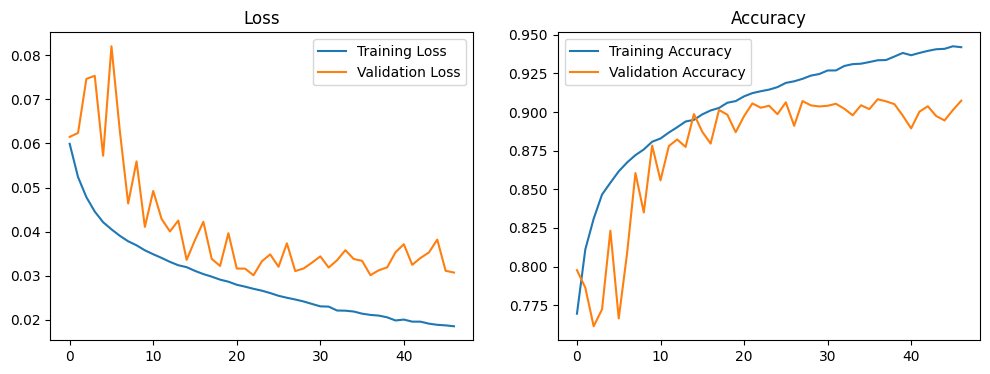

1712/1719 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - AUC: 0.9657 - accuracy: 0.9086 - loss: 0.0297

2025-04-11 13:06:28.116789: I external/local_xla/xla/stream_executor/cuda/subprocess_compilation.cc:346] ptxas warning : Registers are spilled to local memory in function 'gemm_fusion_dot_152', 188 bytes spill stores, 188 bytes spill loads

2025-04-11 13:06:28.346673: I external/local_xla/xla/stream_executor/cuda/subprocess_compilation.cc:346] ptxas warning : Registers are spilled to local memory in function 'gemm_fusion_dot_152', 36 bytes spill stores, 36 bytes spill loads

2025-04-11 13:06:28.398834: I external/local_xla/xla/stream_executor/cuda/subprocess_compilation.cc:346] ptxas warning : Registers are spilled to local memory in function 'gemm_fusion_dot_152', 268 bytes spill stores, 328 bytes spill loads



1719/1719 ━━━━━━━━━━━━━━━━━━━━ 12s 7ms/step - AUC: 0.9657 - accuracy: 0.9086 - loss: 0.0297
Test Loss: 0.030443692579865456
Test Accuracy: 0.9070845246315002
Test AUC: 0.964438796043396


In [19]:
cnn_layers = generate_cnn_layers(
    cnn_layers=[(48, 3, True), (96, 3, True), (192, 3, True)],
    regularization='dropout',
    dropout_rate=0.25)

model6 = create_cnn_model(cnn_layers, center_crop=64, image_rescaling=True, fc_layers=[256, 512], fc_regularization='dropout')

model6.compile(optimizer=keras.optimizers.Adam(learning_rate=0.0001), 
               loss=keras.losses.BinaryFocalCrossentropy(apply_class_balancing=True, alpha=0.4), 
               metrics=['accuracy', 'AUC'])
model6 = train_model(model6, 'cnn_64_model6', X_train, y_train)
evaluate_model_and_print_results(model6, X_test, y_test)

Epoch 1/100
4126/4126 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - AUC: 0.7878 - accuracy: 0.7274 - loss: 0.0680 
Epoch 1: val_AUC improved from -inf to 0.87622, saving model to cnn_96_model7.best_weights.keras
4126/4126 ━━━━━━━━━━━━━━━━━━━━ 75s 17ms/step - AUC: 0.7878 - accuracy: 0.7274 - loss: 0.0680 - val_AUC: 0.8762 - val_accuracy: 0.8012 - val_loss: 0.0614
Epoch 2/100
4123/4126 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - AUC: 0.8831 - accuracy: 0.8061 - loss: 0.0528 
Epoch 2: val_AUC improved from 0.87622 to 0.90597, saving model to cnn_96_model7.best_weights.keras
4126/4126 ━━━━━━━━━━━━━━━━━━━━ 61s 15ms/step - AUC: 0.8831 - accuracy: 0.8061 - loss: 0.0528 - val_AUC: 0.9060 - val_accuracy: 0.7962 - val_loss: 0.0616
Epoch 3/100
4125/4126 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - AUC: 0.9105 - accuracy: 0.8335 - loss: 0.0467 
Epoch 3: val_AUC improved from 0.90597 to 0.92283, saving model to cnn_96_model7.best_weights.keras
4126/4126 ━━━━━━━━━━━━━━━━━━━━ 60s 15ms/step - AUC: 0.9105 - accuracy: 0.8336 - lo

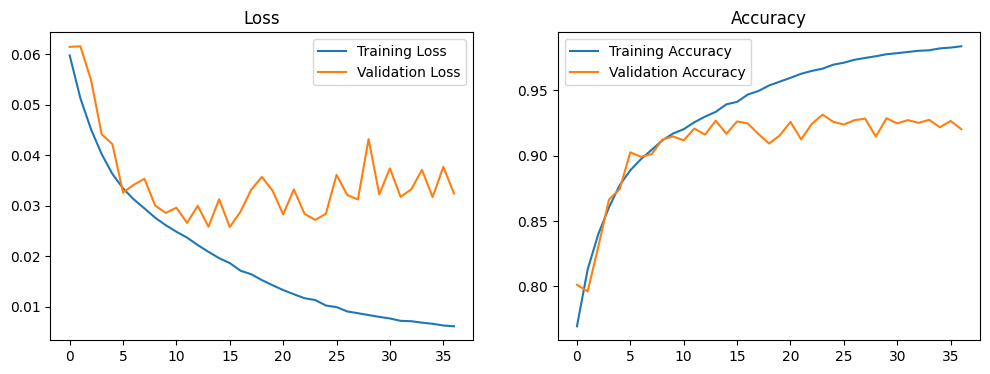

1719/1719 ━━━━━━━━━━━━━━━━━━━━ 10s 6ms/step - AUC: 0.9791 - accuracy: 0.9329 - loss: 0.0302
Test Loss: 0.03129944950342178
Test Accuracy: 0.9306088089942932
Test AUC: 0.9784033894538879


In [20]:
cnn_layers = generate_cnn_layers(
    cnn_layers=[(48, 3, True), (96, 3, True), (192, 3, True)],
    regularization='dropout',
    dropout_rate=0.25)

model7 = create_cnn_model(cnn_layers, center_crop=96, image_rescaling=True, fc_layers=[768], fc_regularization='dropout')

model7.compile(optimizer=keras.optimizers.Adam(learning_rate=0.0001), 
               loss=keras.losses.BinaryFocalCrossentropy(apply_class_balancing=True, alpha=0.4), 
               metrics=['accuracy', 'AUC'])
model7 = train_model(model7, 'cnn_96_model7', X_train, y_train)
evaluate_model_and_print_results(model7, X_test, y_test)

Epoch 1/100
4126/4126 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step - AUC: 0.7823 - accuracy: 0.7249 - loss: 0.0660 

2025-04-11 14:03:50.622129: I external/local_xla/xla/stream_executor/cuda/subprocess_compilation.cc:346] ptxas warning : Registers are spilled to local memory in function 'gemm_fusion_dot_170', 60 bytes spill stores, 60 bytes spill loads

2025-04-11 14:03:50.837713: I external/local_xla/xla/stream_executor/cuda/subprocess_compilation.cc:346] ptxas warning : Registers are spilled to local memory in function 'gemm_fusion_dot_170', 32 bytes spill stores, 32 bytes spill loads

2025-04-11 14:03:50.957044: I external/local_xla/xla/stream_executor/cuda/subprocess_compilation.cc:346] ptxas warning : Registers are spilled to local memory in function 'gemm_fusion_dot_170_0', 52 bytes spill stores, 52 bytes spill loads

2025-04-11 14:03:51.038914: I external/local_xla/xla/stream_executor/cuda/subprocess_compilation.cc:346] ptxas warning : Registers are spilled to local memory in function 'gemm_fusion_dot_170', 300 bytes spill stores, 636 bytes spill loads

2025-04-11 14:03:51.199992: I external/l


Epoch 1: val_AUC improved from -inf to 0.87359, saving model to cnn_96_model8.best_weights.keras
4126/4126 ━━━━━━━━━━━━━━━━━━━━ 87s 20ms/step - AUC: 0.7823 - accuracy: 0.7249 - loss: 0.0660 - val_AUC: 0.8736 - val_accuracy: 0.7339 - val_loss: 0.0783
Epoch 2/100
4123/4126 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - AUC: 0.8932 - accuracy: 0.8199 - loss: 0.0505 
Epoch 2: val_AUC improved from 0.87359 to 0.90738, saving model to cnn_96_model8.best_weights.keras
4126/4126 ━━━━━━━━━━━━━━━━━━━━ 64s 15ms/step - AUC: 0.8932 - accuracy: 0.8199 - loss: 0.0505 - val_AUC: 0.9074 - val_accuracy: 0.7020 - val_loss: 0.0829
Epoch 3/100
4122/4126 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - AUC: 0.9237 - accuracy: 0.8497 - loss: 0.0433 
Epoch 3: val_AUC improved from 0.90738 to 0.93205, saving model to cnn_96_model8.best_weights.keras
4126/4126 ━━━━━━━━━━━━━━━━━━━━ 64s 16ms/step - AUC: 0.9237 - accuracy: 0.8497 - loss: 0.0433 - val_AUC: 0.9320 - val_accuracy: 0.8143 - val_loss: 0.0590
Epoch 4/100
4124/4126 ━━━━━━━━━━━

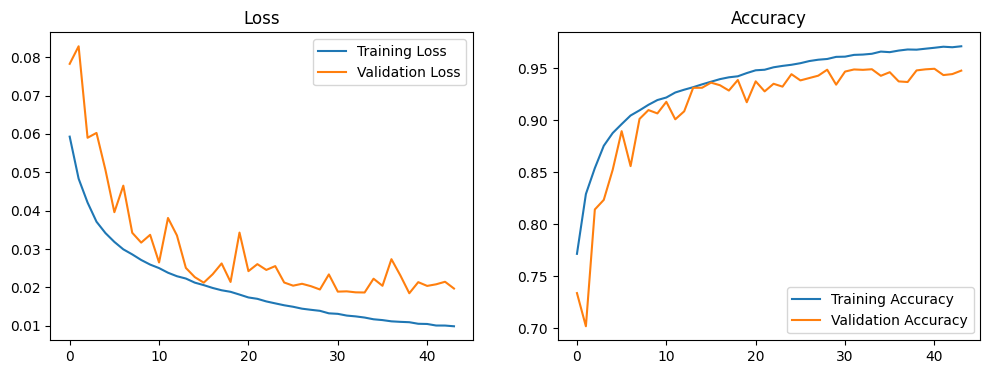

1714/1719 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - AUC: 0.9879 - accuracy: 0.9498 - loss: 0.0185 

2025-04-11 14:50:16.536035: I external/local_xla/xla/stream_executor/cuda/subprocess_compilation.cc:346] ptxas warning : Registers are spilled to local memory in function 'gemm_fusion_dot_170_0', 44 bytes spill stores, 44 bytes spill loads

2025-04-11 14:50:16.621727: I external/local_xla/xla/stream_executor/cuda/subprocess_compilation.cc:346] ptxas warning : Registers are spilled to local memory in function 'gemm_fusion_dot_170', 48 bytes spill stores, 48 bytes spill loads

2025-04-11 14:50:16.660961: I external/local_xla/xla/stream_executor/cuda/subprocess_compilation.cc:346] ptxas warning : Registers are spilled to local memory in function 'gemm_fusion_dot_170', 36 bytes spill stores, 36 bytes spill loads

2025-04-11 14:50:16.909446: I external/local_xla/xla/stream_executor/cuda/subprocess_compilation.cc:346] ptxas warning : Registers are spilled to local memory in function 'gemm_fusion_dot_170', 316 bytes spill stores, 748 bytes spill loads

2025-04-11 14:50:16.923420: I external/l

1719/1719 ━━━━━━━━━━━━━━━━━━━━ 15s 9ms/step - AUC: 0.9879 - accuracy: 0.9498 - loss: 0.0185
Test Loss: 0.018415547907352448
Test Accuracy: 0.9506244659423828
Test AUC: 0.9877853393554688


In [22]:
cnn_layers = generate_cnn_layers(
    cnn_layers=[(48, 3, True), (96, 3, True), (192, 3, True), (384, 3, True)],
    regularization='dropout',
    dropout_rate=0.25)

model8 = create_cnn_model(cnn_layers, center_crop=96, image_rescaling=True, fc_layers=[512, 1024], fc_regularization='dropout')

model8.compile(optimizer=keras.optimizers.Adam(learning_rate=0.0001), 
               loss=keras.losses.BinaryFocalCrossentropy(apply_class_balancing=True, alpha=0.4), 
               metrics=['accuracy', 'AUC'])
model8 = train_model(model8, 'cnn_96_model8', X_train, y_train)
evaluate_model_and_print_results(model8, X_test, y_test)

In [23]:
test_images, test_ids = get_test_images(data_dir)
print(test_images.shape)



(57458, 96, 96, 3)


In [24]:
generate_submission(model1, test_images, test_ids, 'model1')
generate_submission(model2, test_images, test_ids, 'model2')
generate_submission(model3, test_images, test_ids, 'model3')
generate_submission(model4, test_images, test_ids, 'model4')
generate_submission(model5, test_images, test_ids, 'model5')
generate_submission(model6, test_images, test_ids, 'model6')
generate_submission(model7, test_images, test_ids, 'model7')
generate_submission(model8, test_images, test_ids, 'model8')


1796/1796 ━━━━━━━━━━━━━━━━━━━━ 7s 3ms/step
Submission saved to submission_model1.csv
1796/1796 ━━━━━━━━━━━━━━━━━━━━ 6s 3ms/step
Submission saved to submission_model2.csv
1796/1796 ━━━━━━━━━━━━━━━━━━━━ 7s 4ms/step
Submission saved to submission_model3.csv
1796/1796 ━━━━━━━━━━━━━━━━━━━━ 7s 3ms/step
Submission saved to submission_model4.csv
1796/1796 ━━━━━━━━━━━━━━━━━━━━ 9s 5ms/step
Submission saved to submission_model5.csv
1790/1796 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step

2025-04-11 14:52:45.054086: I external/local_xla/xla/stream_executor/cuda/subprocess_compilation.cc:346] ptxas warning : Registers are spilled to local memory in function 'gemm_fusion_dot_105', 188 bytes spill stores, 188 bytes spill loads

2025-04-11 14:52:45.185376: I external/local_xla/xla/stream_executor/cuda/subprocess_compilation.cc:346] ptxas warning : Registers are spilled to local memory in function 'gemm_fusion_dot_105', 36 bytes spill stores, 36 bytes spill loads

2025-04-11 14:52:45.375085: I external/local_xla/xla/stream_executor/cuda/subprocess_compilation.cc:346] ptxas warning : Registers are spilled to local memory in function 'gemm_fusion_dot_105', 268 bytes spill stores, 328 bytes spill loads



1796/1796 ━━━━━━━━━━━━━━━━━━━━ 11s 5ms/step
Submission saved to submission_model6.csv
1796/1796 ━━━━━━━━━━━━━━━━━━━━ 9s 4ms/step
Submission saved to submission_model7.csv
1789/1796 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step

2025-04-11 14:53:25.922581: I external/local_xla/xla/stream_executor/cuda/subprocess_compilation.cc:346] ptxas warning : Registers are spilled to local memory in function 'gemm_fusion_dot_123_0', 44 bytes spill stores, 44 bytes spill loads

2025-04-11 14:53:25.986670: I external/local_xla/xla/stream_executor/cuda/subprocess_compilation.cc:346] ptxas warning : Registers are spilled to local memory in function 'gemm_fusion_dot_123', 36 bytes spill stores, 36 bytes spill loads

2025-04-11 14:53:26.046706: I external/local_xla/xla/stream_executor/cuda/subprocess_compilation.cc:346] ptxas warning : Registers are spilled to local memory in function 'gemm_fusion_dot_123', 48 bytes spill stores, 48 bytes spill loads

2025-04-11 14:53:26.114830: I external/local_xla/xla/stream_executor/cuda/subprocess_compilation.cc:346] ptxas warning : Registers are spilled to local memory in function 'gemm_fusion_dot_123', 316 bytes spill stores, 748 bytes spill loads

2025-04-11 14:53:26.221406: I external/l

1796/1796 ━━━━━━━━━━━━━━━━━━━━ 12s 6ms/step
Submission saved to submission_model8.csv
